<a href="https://colab.research.google.com/github/poralapoornachandra/carpet_anomaly_detection_/blob/main/Anamoly_detection_using_resnet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

In [3]:

# from zipfile import ZipFile

# data_path = '/content/drive/MyDrive/carpet (2).zip'
# with ZipFile(data_path, 'r') as zip:
#   zip.extractall()
#   print('The dataset has been extracted.')

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_image_path = Path('/content/drive/MyDrive/carpet/train')

good_dataset = ImageFolder(root=train_image_path, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

In [5]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

for name in resnet_model.named_parameters():
    print(name[0])

resnet_model.layer2

def hook(model, input, output):
    feature.append(output.detach())

feature =[]
resnet_model.layer2[-1].register_forward_hook(hook)
resnet_model.layer3[-1].register_forward_hook(hook)

_ = resnet_model(torch.randn(1,3,224,224))

feature[1].shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.6MB/s]


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

torch.Size([1, 1024, 14, 14])

**Load a pretrained nesnet model**

In [6]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False



        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps

        return patch

torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 1536, 28, 28])


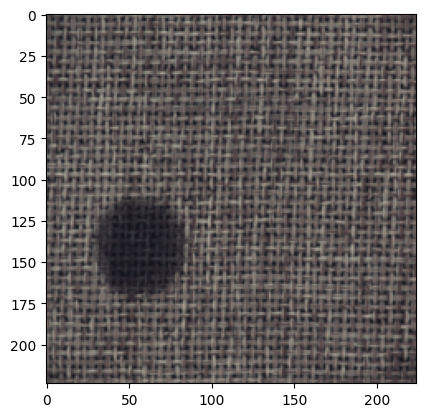

In [7]:
image = Image.open(r'/content/drive/MyDrive/carpet/test/color/000.png')
image = transform(image).unsqueeze(0)

backbone = resnet_feature_extractor()
feature = backbone(image)

print(backbone.features[0].shape)
print(backbone.features[1].shape)

print(feature.shape)

plt.imshow(image[0].permute(1,2,0))

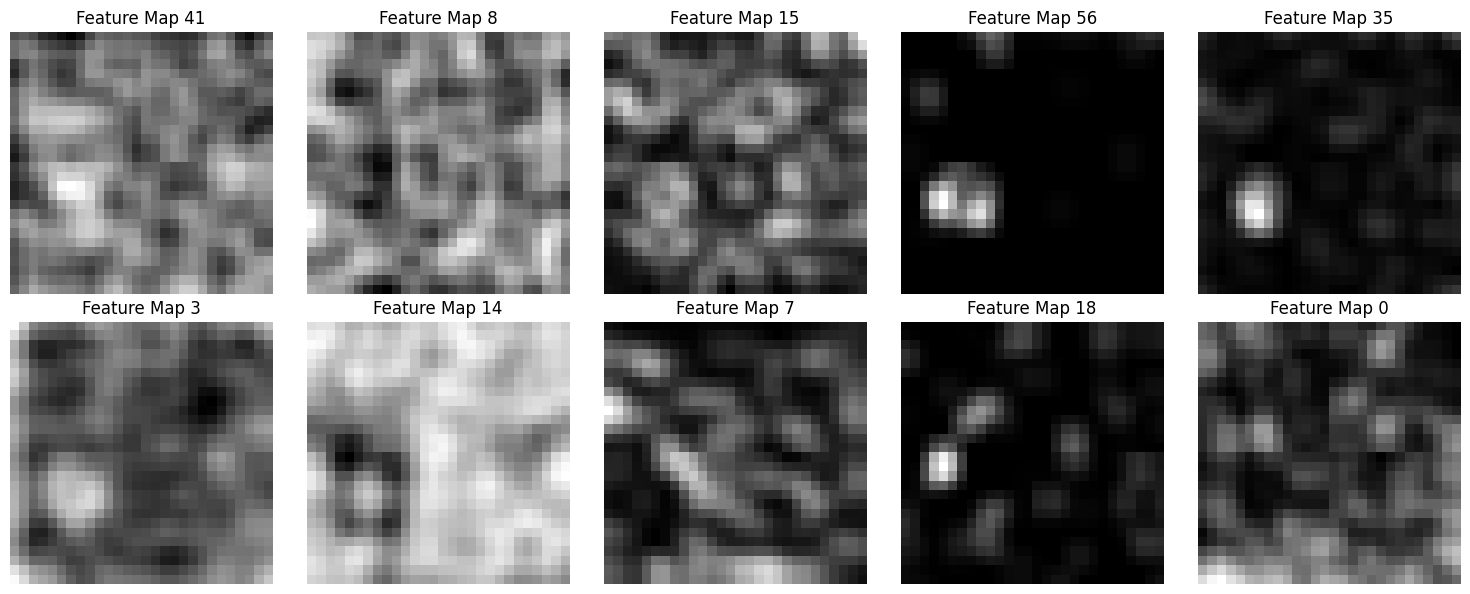

In [8]:
# Select 10 random indices for feature maps
indices = torch.randperm(64)[:10]

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0,idx].detach().cpu(), cmap='gray')
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

**The auto encoder model  **

In [9]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""

    def __init__(self, in_channels=1000, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        # if 1x1 conv to reconstruct the rgb values, we try to learn a linear combination
        # of the features for rgb
        layers = []
        layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]
        # layers += [nn.ReLU()]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
backbone.cuda()
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
import os

# Create a new directory (e.g., "my_folder" in current working directory)
os.makedirs("autoencoder_with_resnet_deep_features.pth", exist_ok=True)


In [12]:
# ckpoints = torch.load('/content/autoencoder_with_resnet_deep_features.pth')
# model.load_state_dict(ckpoints)

# model.eval()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.0927, Validation Loss: 0.2742
Epoch [6/50], Loss: 0.0238, Validation Loss: 0.0237
Epoch [11/50], Loss: 0.0201, Validation Loss: 0.0196
Epoch [16/50], Loss: 0.0165, Validation Loss: 0.0166
Epoch [21/50], Loss: 0.0147, Validation Loss: 0.0145
Epoch [26/50], Loss: 0.0129, Validation Loss: 0.0130
Epoch [31/50], Loss: 0.0116, Validation Loss: 0.0118
Epoch [36/50], Loss: 0.0109, Validation Loss: 0.0110
Epoch [41/50], Loss: 0.0100, Validation Loss: 0.0104
Epoch [46/50], Loss: 0.0096, Validation Loss: 0.0099


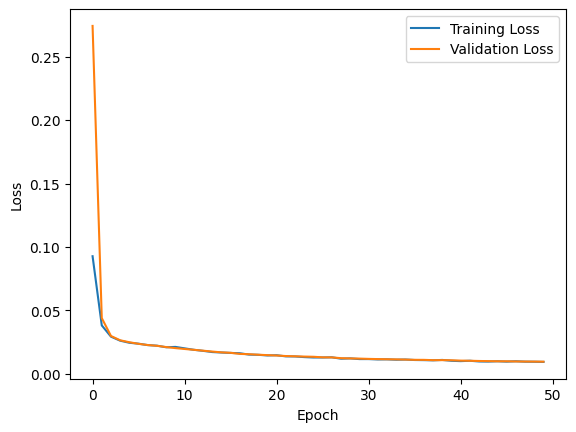

In [13]:
import torch.nn as nn
import torchvision.models as models

# Example custom Autoencoder using a ResNet backbone
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove last layers

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel))

# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data,_ in train_loader:
        with torch.no_grad():
            features = backbone(data.cuda())
        # Forward pass
        output = model(features)
        # Compute the loss
        loss = criterion(output, features)
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data, _ in test_loader:
            features = backbone(data.cuda())
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
 #  torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_features.pth')
torch.save(model, 'autoencoder_with_resnet_deep_features1.pth')


In [ ]:
from google.colab import files
files.download('autoencoder_with_resnet_deep_features1.pth')

In [ ]:
# model = r"/content/autoencoder_with_resnet_deep_features1.pth"

**Prediction of heatmap**

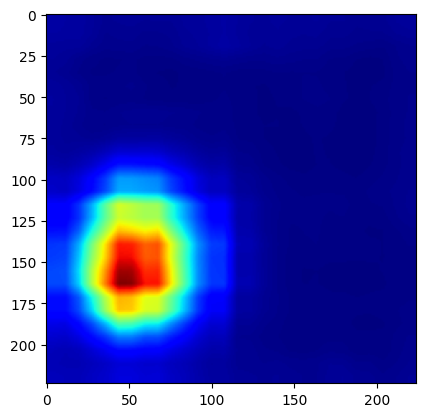

In [14]:
image = Image.open('/content/drive/MyDrive/carpet/test/color/000.png')
image = transform(image).unsqueeze(0)

with torch.no_grad():
    features = backbone(image.cuda())
    recon = model(features)

recon_error =  ((features-recon)**2).mean(axis=(1)).unsqueeze(0)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                recon_error,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.squeeze().cpu().numpy(), cmap='jet')
plt.show()

**For Ok images**

In [15]:
def decision_function(segm_map):

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [16]:
model.eval()

RECON_ERROR=[]
for data,_ in train_loader:

    with torch.no_grad():
        features = backbone(data.cuda()).squeeze()
        # Forward pass
        recon = model(features)
    # Compute the loss
    segm_map =  ((features-recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    anomaly_score = decision_function(segm_map)
    # anomaly_score = segm_map.mean(axis=(1,2))

    RECON_ERROR.append(anomaly_score)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

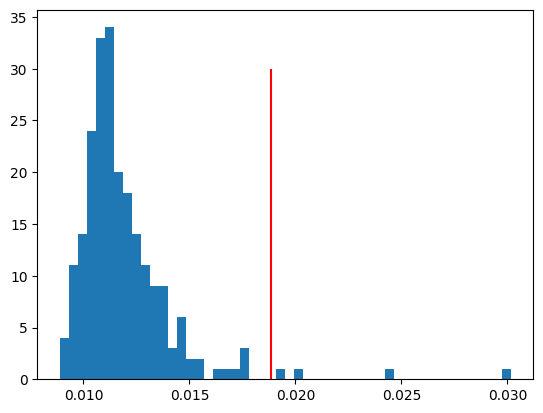

In [17]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

**For Test Images**

In [18]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()
backbone.eval()

test_path = Path('/content/drive/MyDrive/carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)

    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)

    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))

    y_pred_image = 1*(y_score_image >= best_threshold)

    y_true_image = 0 if fault_type == 'good' else 1

    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu().numpy())
    y_score.append(y_score_image.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

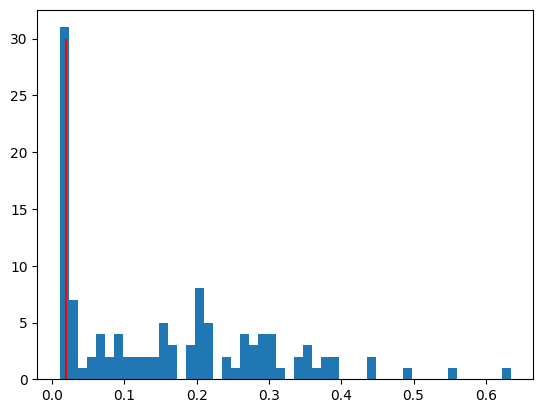

In [19]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.9827447833065811


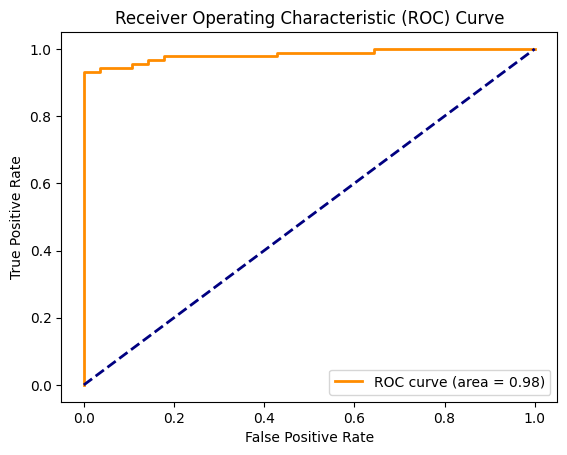

best_threshold = 0.024782635271549225


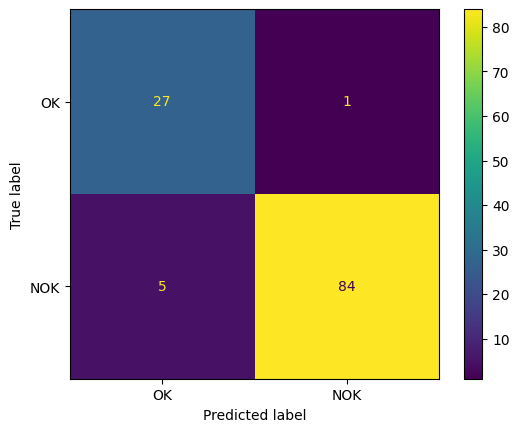

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

**Printout the prediction on the test set**

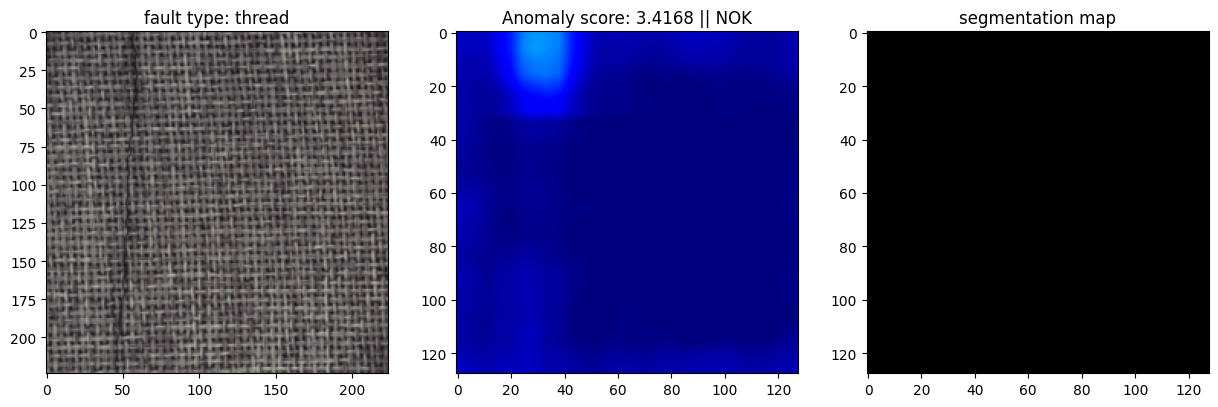

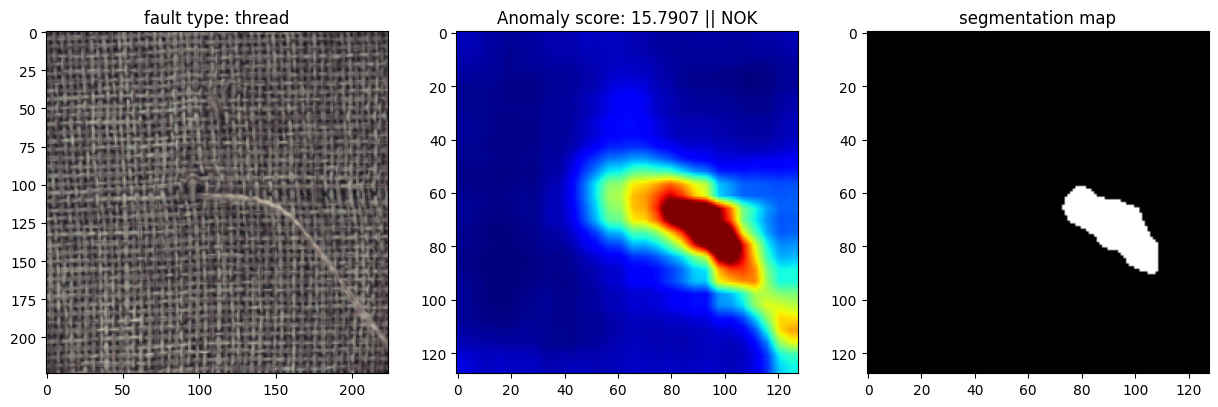

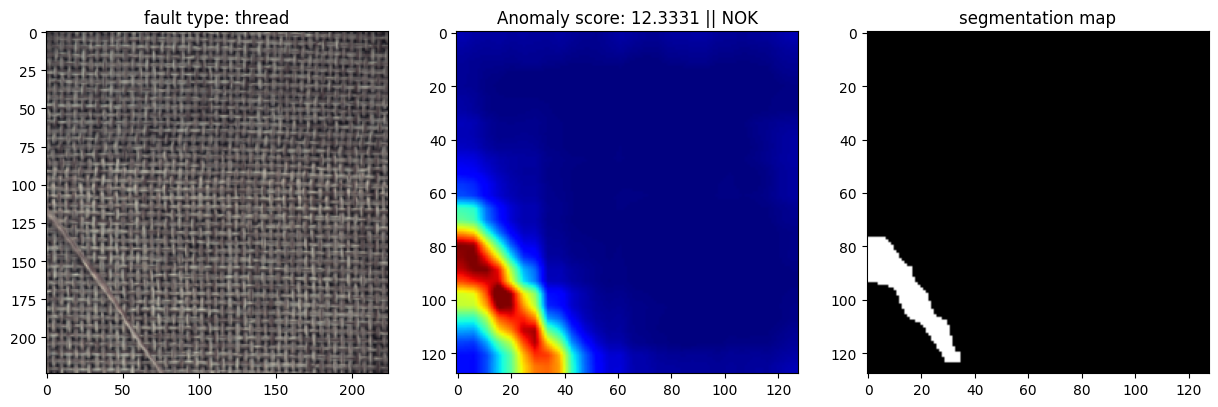

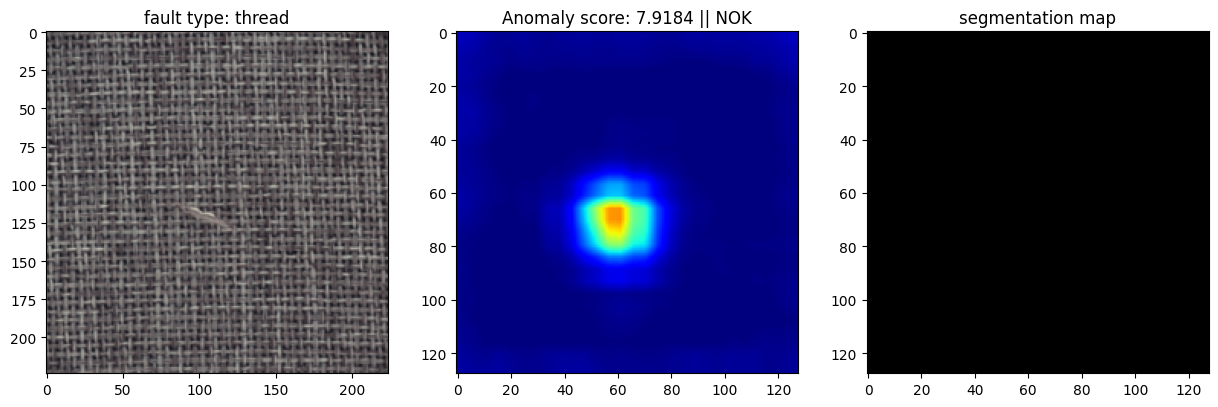

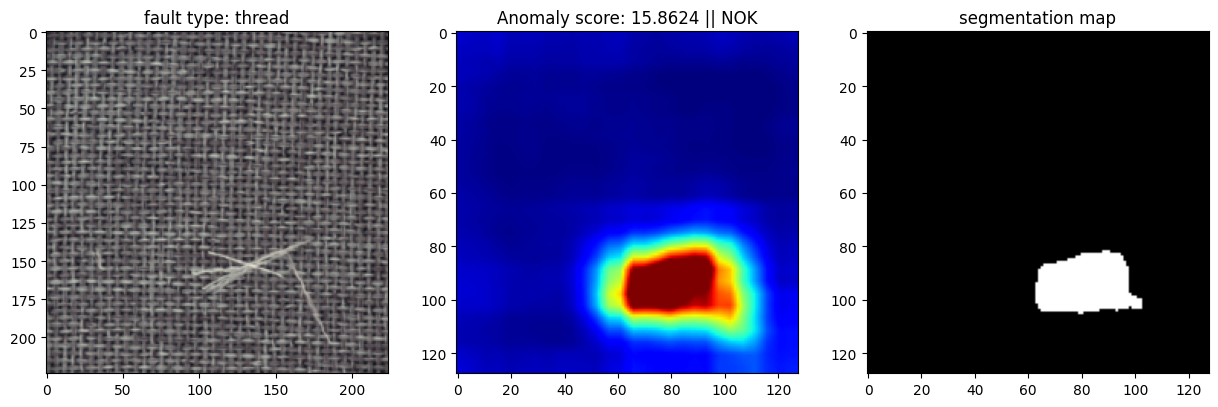

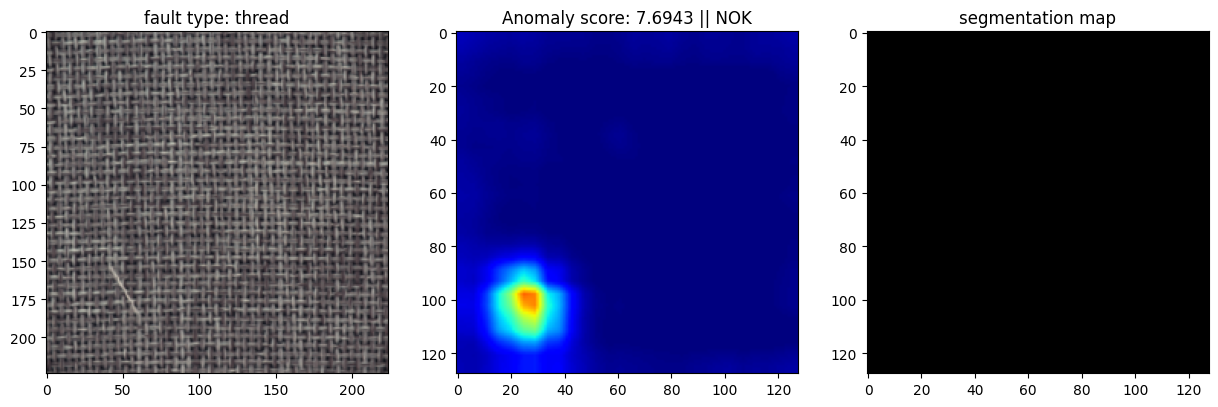

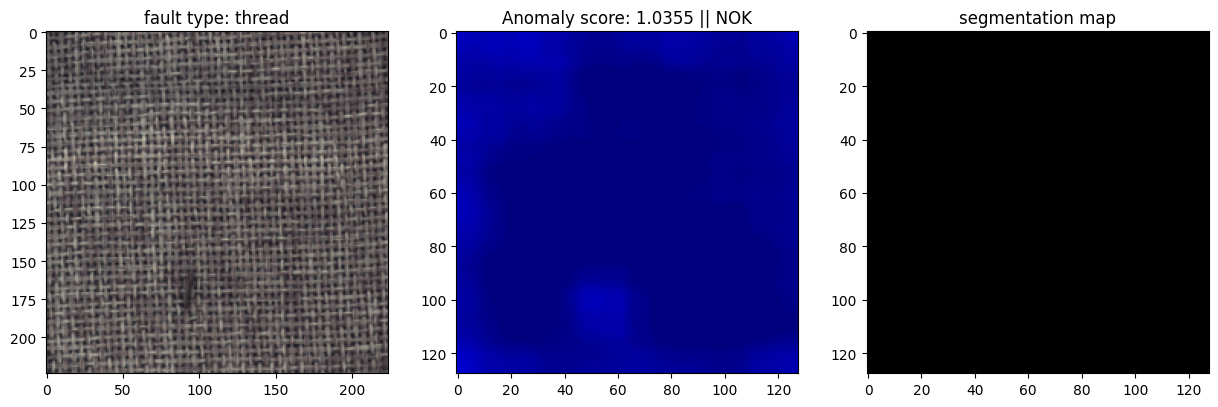

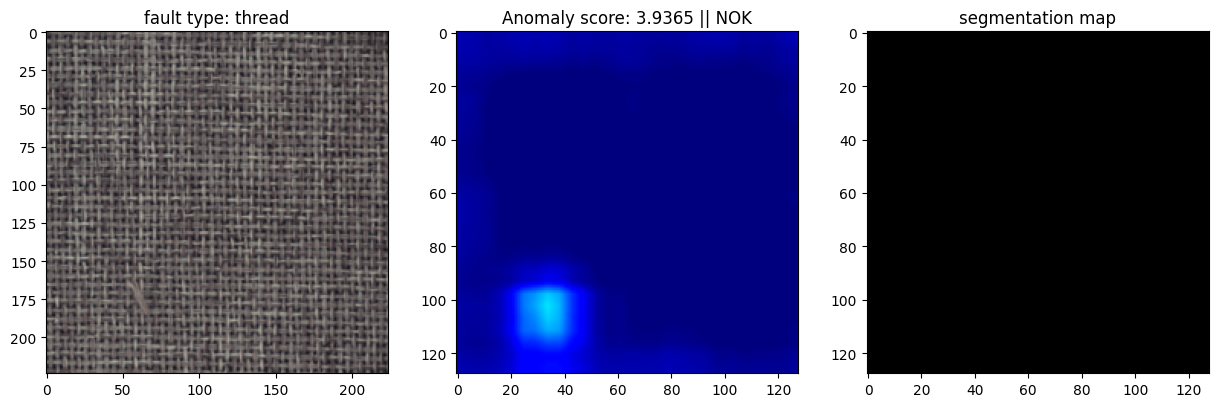

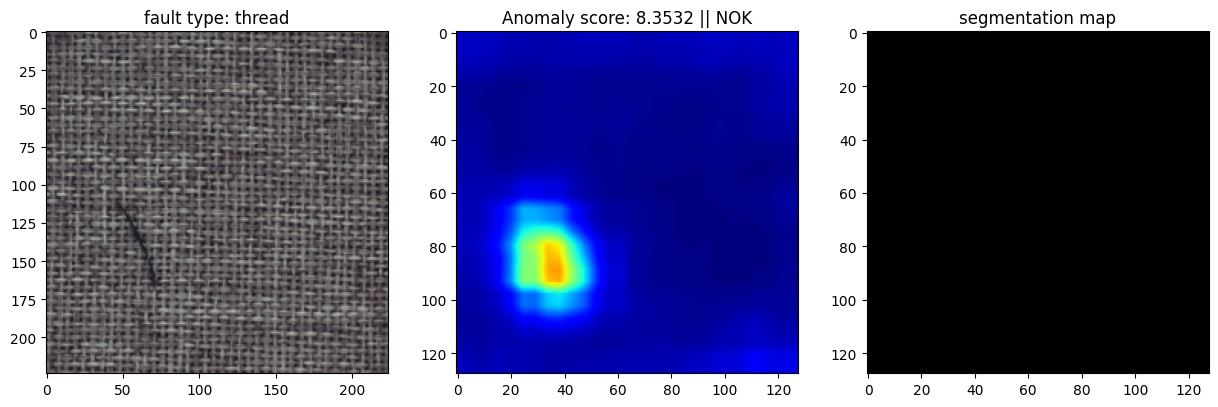

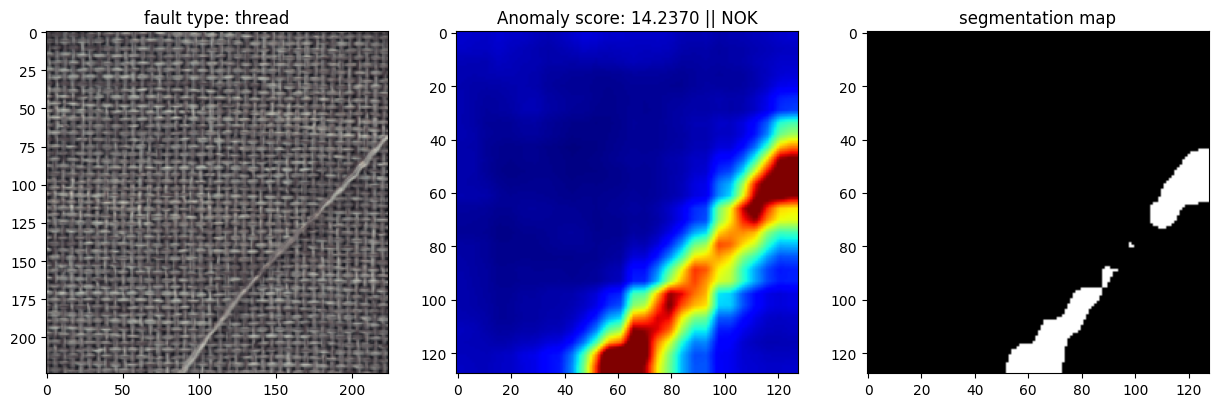

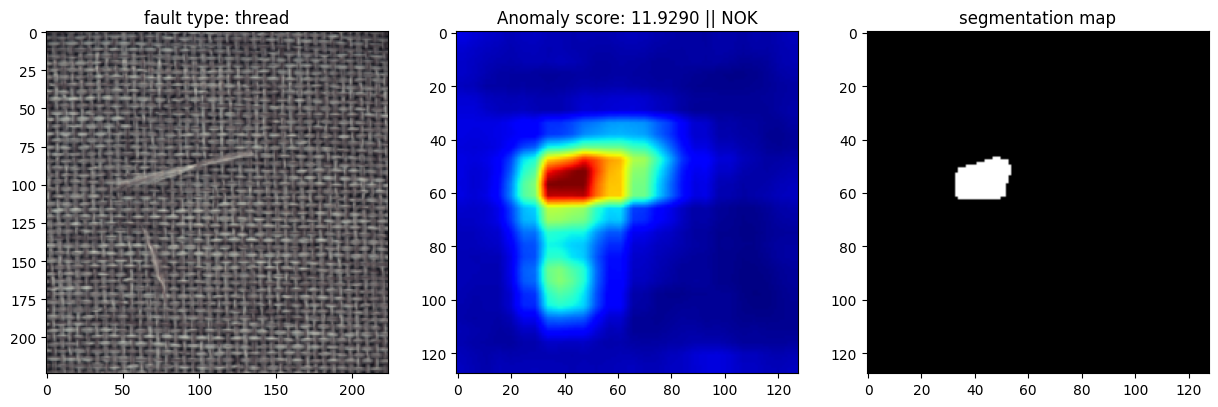

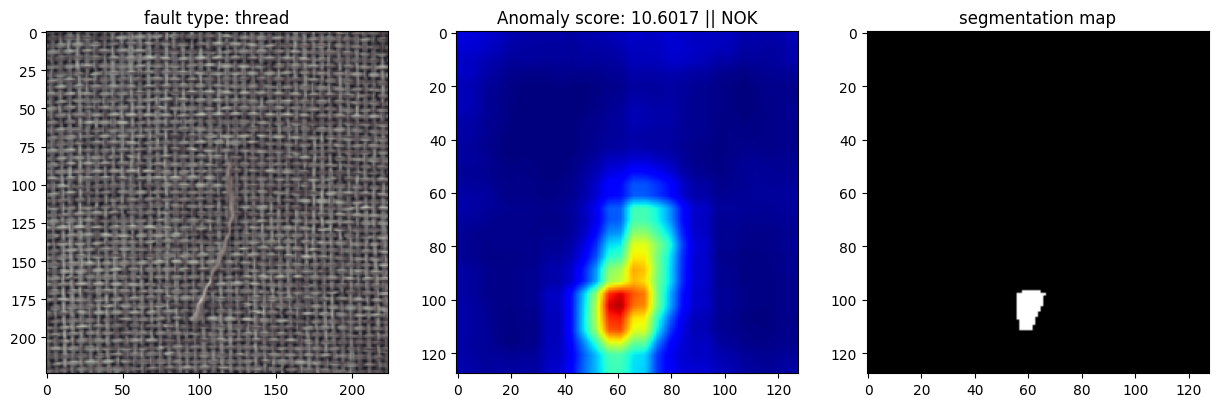

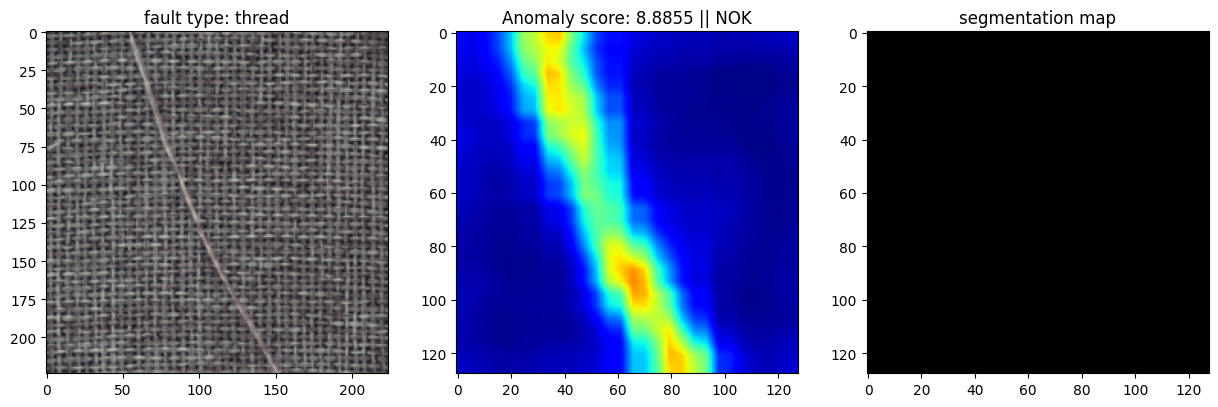

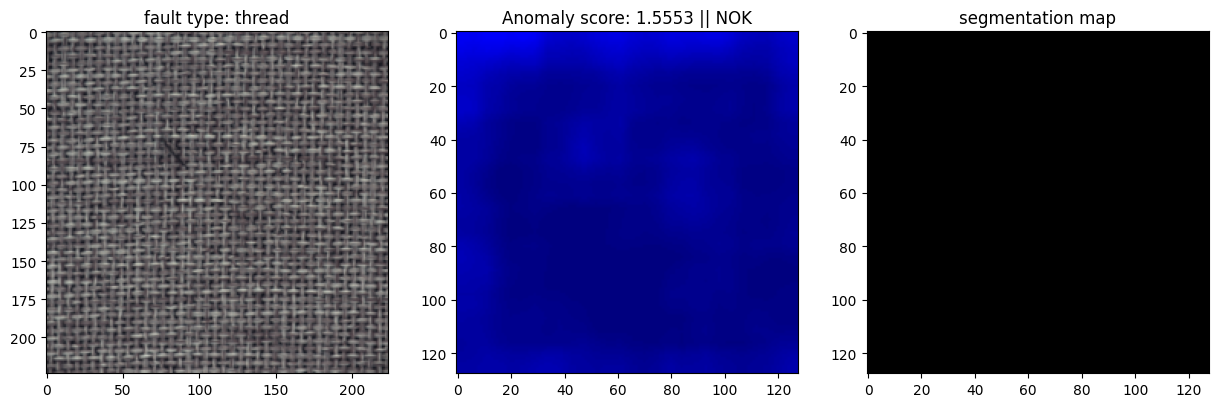

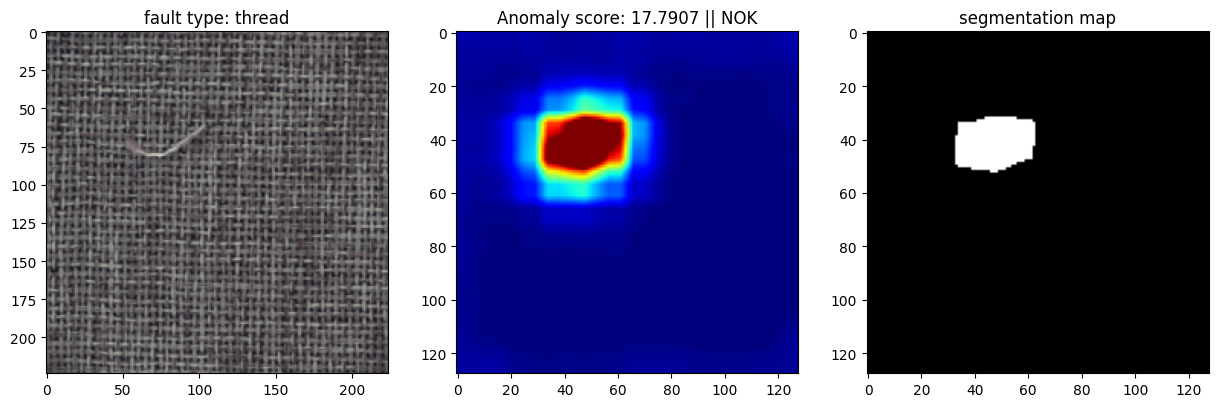

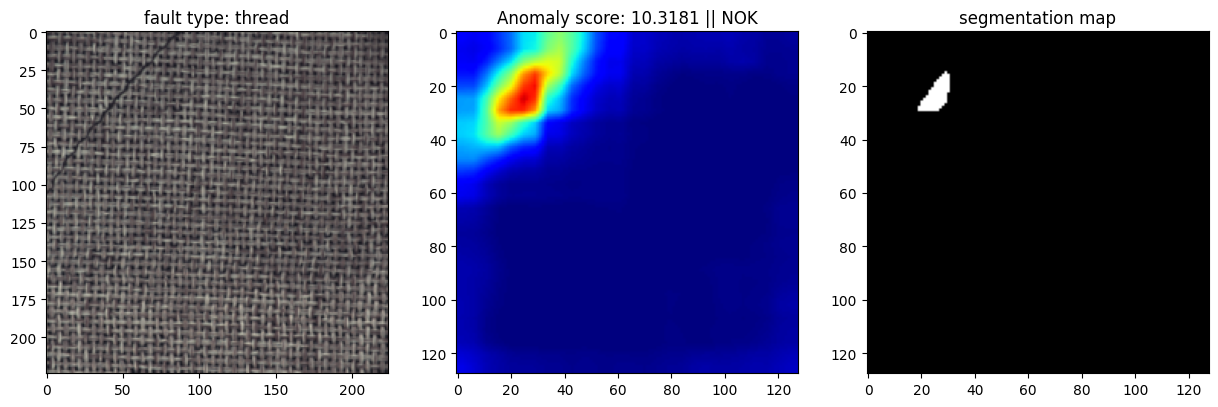

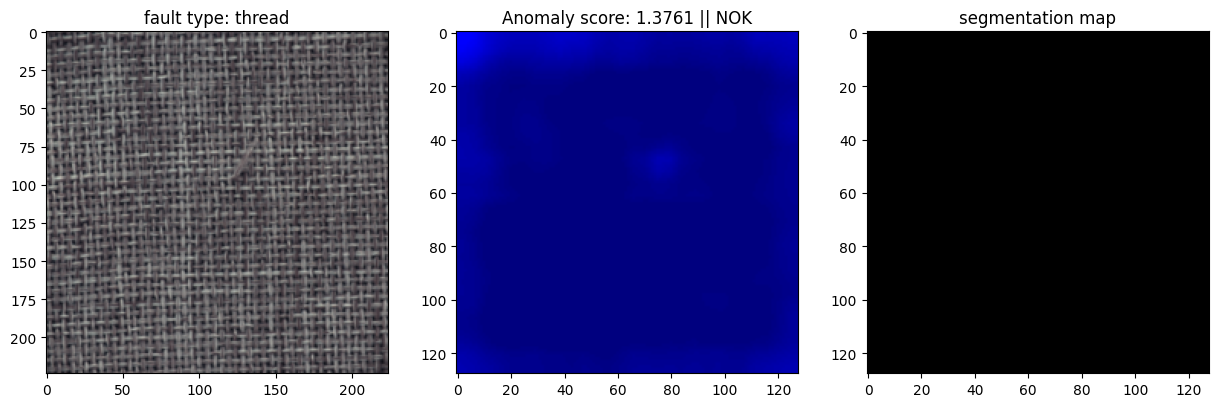

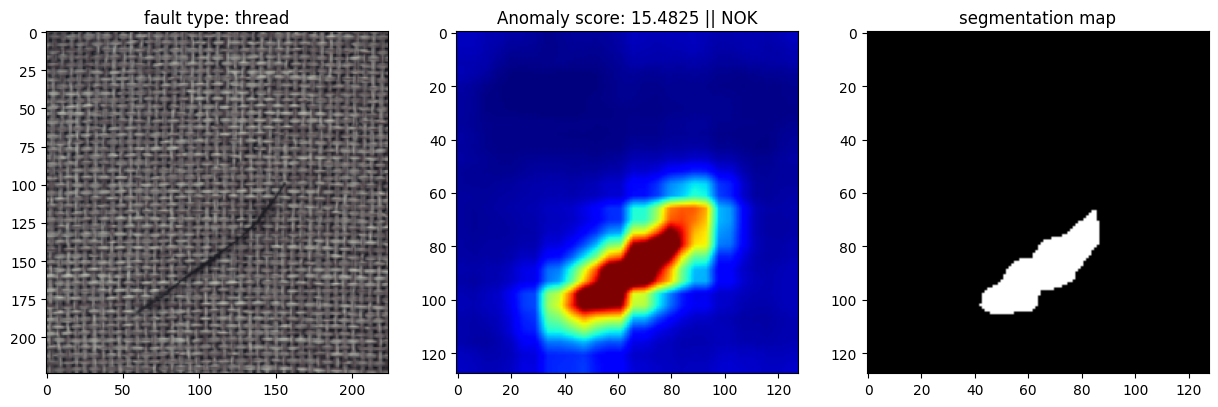

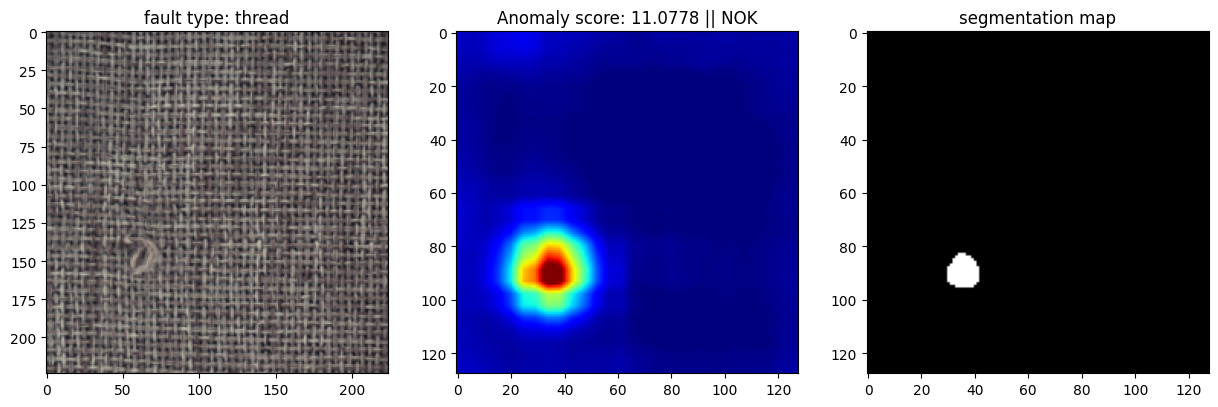

In [21]:
import cv2, time
from IPython.display import clear_output

model.eval()
backbone.eval()

test_path = Path('/content/drive/MyDrive/carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)

    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)

    segm_map = ((features - recon)**2).mean(axis=(1))
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))

    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']

    if fault_type in ['thread']:

        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,3,2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = heat_map
        heat_map = cv2.resize(heat_map, (128,128))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map_min, vmax=heat_map_max*10) # Here I am cheating by multiplying by 10 (obtained using trail error)
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.subplot(1,3,3)
        plt.imshow((heat_map > best_threshold * 10), cmap='gray')
        plt.title(f'segmentation map')

        # plt.show()
        # time.sleep(0.05)
        # clear_output(wait=True)

        # break

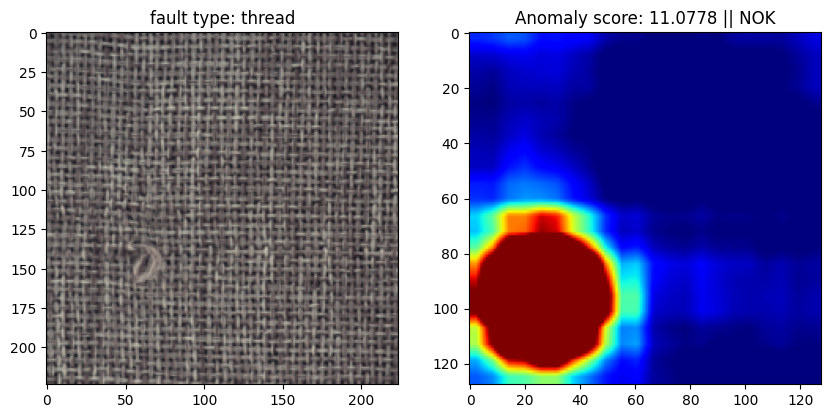

In [22]:
import cv2, time
from IPython.display import clear_output

model.eval()
backbone.eval()

test_path = Path('/content/drive/MyDrive/carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)

    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)

    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))

    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']

    if fault_type in ['color','thread']:

        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,2,2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = heat_map
        heat_map = cv2.resize(heat_map, (128,128))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map_min, vmax=heat_map_max*2)
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.show()

        time.sleep(0.05)
        clear_output(wait=True)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Compute metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['OK', 'NOK']))

# Print summary
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")



Classification Report:
               precision    recall  f1-score   support

          OK       0.91      0.71      0.80        28
         NOK       0.92      0.98      0.95        89

    accuracy                           0.91       117
   macro avg       0.91      0.85      0.87       117
weighted avg       0.91      0.91      0.91       117

Precision: 0.9158
Recall:    0.9775
F1 Score:  0.9457
Accuracy:  0.9145


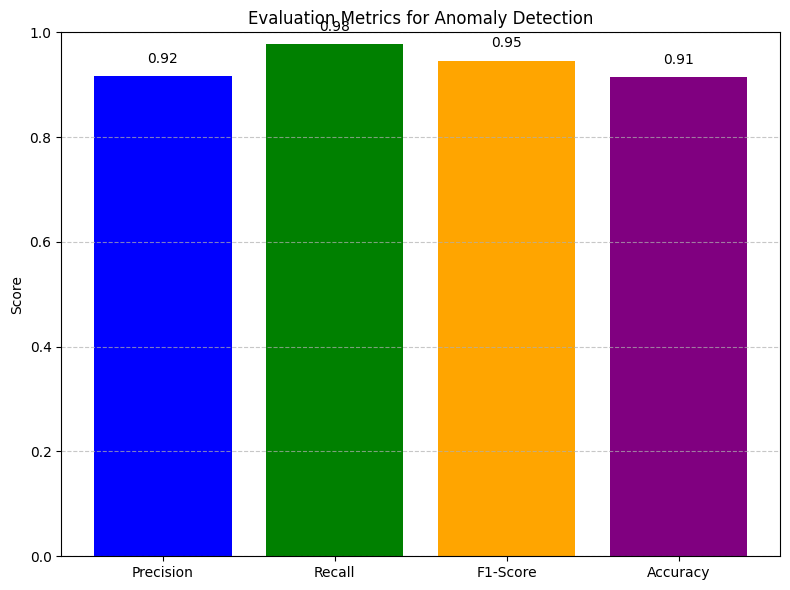

In [24]:
# Plot bar chart
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [precision, recall, f1, accuracy]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics for Anomaly Detection')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


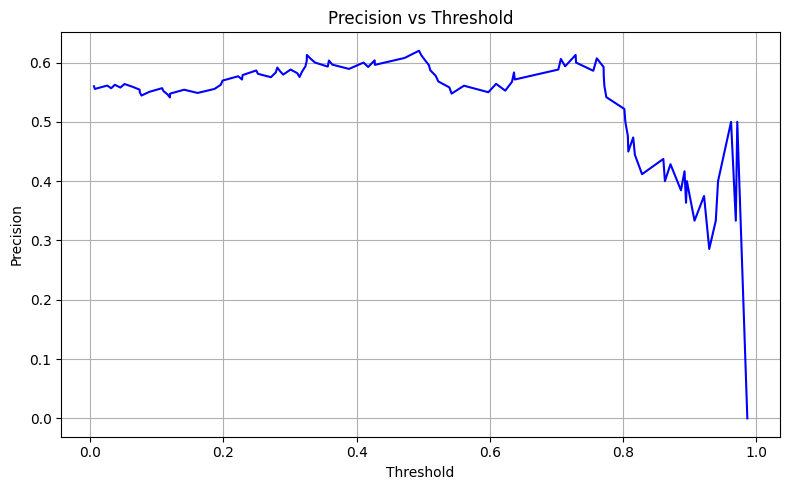

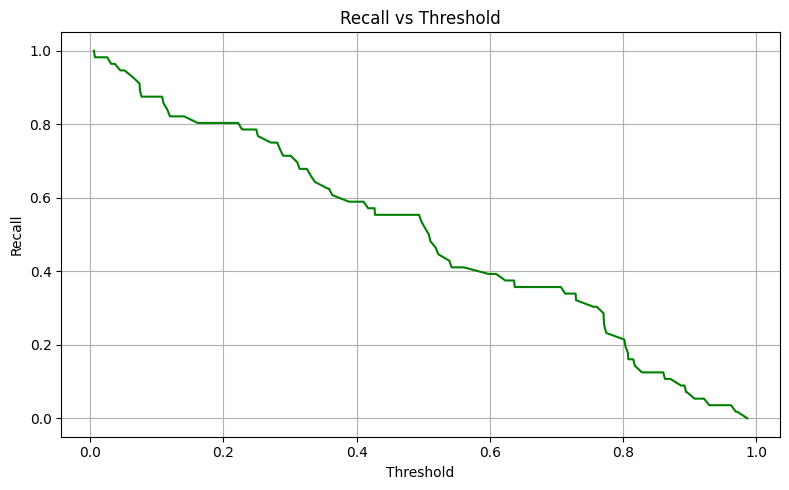

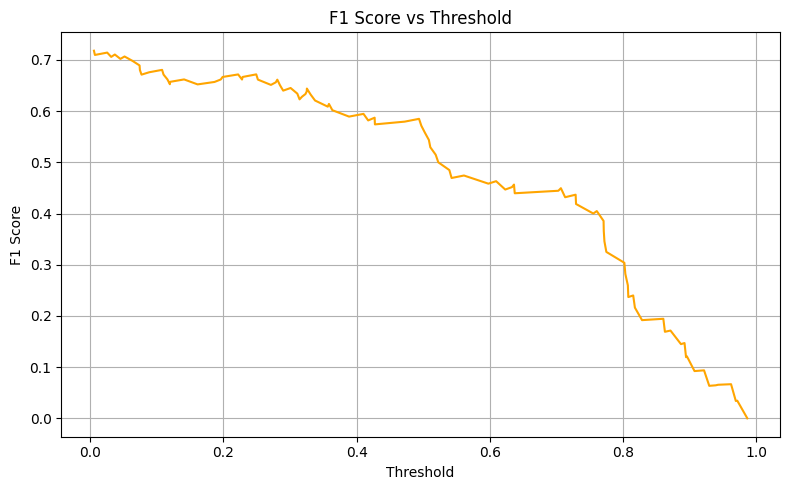

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Replace these with your actual model output
# y_true = np.array([...])      # True labels (0 or 1)
# y_scores = np.array([...])    # Anomaly scores or predicted probabilities

# Example placeholders — replace when using real data
np.random.seed(42)
y_true = np.random.randint(0, 2, size=100)
y_scores = np.random.rand(100)

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# === 1. Precision vs Threshold ===
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Recall vs Threshold ===
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. F1 Score vs Threshold ===
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s[:-1], label='F1 Score', color='orange')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()


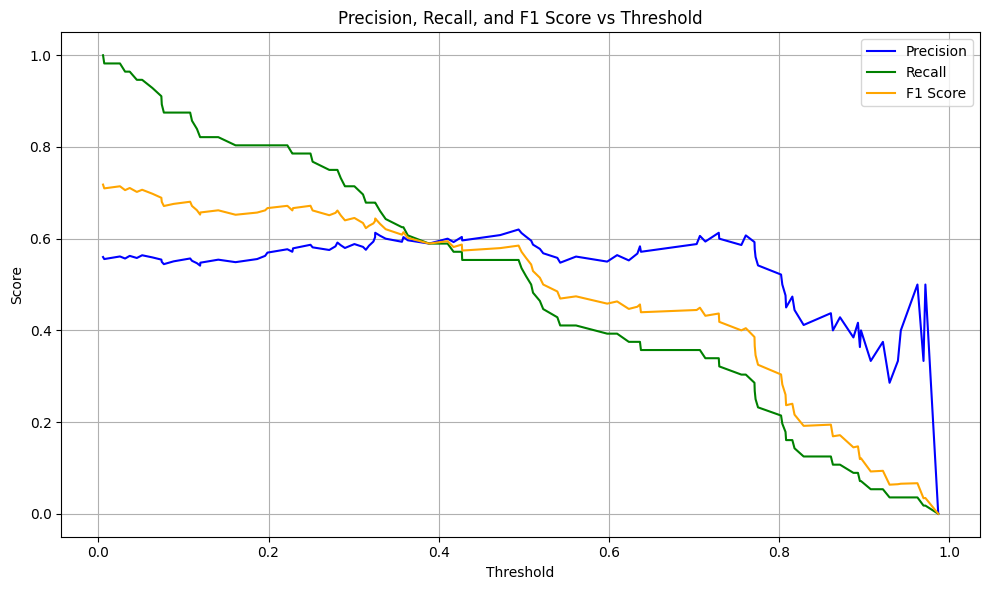

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Assume you already have these from your model
# Replace these with your actual values
# y_true = np.array([...])       # Actual labels (0 or 1)
# y_scores = np.array([...])     # Anomaly scores (continuous values)

# Example placeholders (delete when running on your data)
np.random.seed(42)
y_true = np.random.randint(0, 2, size=100)
y_scores = np.random.rand(100)

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1-scores for each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Plot the metrics vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.plot(thresholds, f1s[:-1], label='F1 Score', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
